In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import pickle 
import cv2
import numpy as np
%matplotlib inline

## Exploring data 

We are using the KITTI and GTI dataset with following directory structure

vehicles ---
         --- GTI_Far/  GTI_Left/  GTI_MiddleClose/  GTI_Right/  KITTI_extracted/

non-vehicles----
          ---  Extras/  GTI/



### Here is a sample 



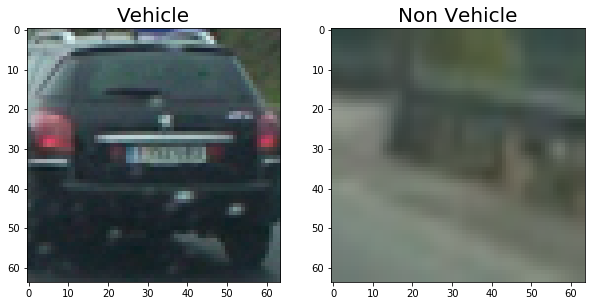

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
vehicle = mpimg.imread("vehicles/GTI_Far/image0816.png")
ax1.imshow(vehicle)
ax1.set_title('Vehicle', fontsize=20)
non_vehicle = mpimg.imread("non-vehicles/GTI/image9.png")
ax2.imshow(non_vehicle)
ax2.set_title('Non Vehicle', fontsize=20)

## Now, let's train classifier
We will using SVM for this 

In [37]:
vehicles = glob("vehicles/*/*.png",recursive=True)
shuffle(vehicles)
non_vehicles = glob("non-vehicles/*/*.png",recursive=True)
shuffle(non_vehicles)

print("No of vehicle sample is {}".format(len(vehicles)))
print("No of Non - vehicle sample is {}".format(len(non_vehicles)))

print("Splitting data ...")

# For splitting data we use Paleto's principle or 80:20 rule
# 80 % data for training and 20 % data for testing our classifier 
rand_state = np.random.randint(0,100)
vehicles_train, vehicles_test = train_test_split(vehicles, train_size = 0.8,random_state=rand_state)
#shuffle(vehicles_train)
#shuffle(vehicles_test)
non_vehicles_train,non_vehicles_test = train_test_split(non_vehicles,train_size=0.8,random_state=rand_state)
#shuffle(non_vehicles_test)
#shuffle(non_vehicles_train)

print("\n---- Vehicles -------\n")
print("No of training vehicle sample is {}".format(len(vehicles_train)))
print("No of test vehicle sample is {}".format(len(vehicles_test)))

print("\n---- Non-Vehicles----\n")
print("No of training non vehicle sample is {}".format(len(non_vehicles_train)))
print("No of test non vehicle sample is {}".format(len(non_vehicles_test)))

print("Saving data ...")
pickle_dict = {}
vehicle_dict = {"train" : vehicles_train, "test" : vehicles_test}
non_vehicle_dict = {"train" : non_vehicles_train, "test" : non_vehicles_test}
pickle_dict["car"] = vehicle_dict
pickle_dict["non_car"] = non_vehicle_dict

with open('data.pickle', 'wb') as file:
    pickle.dump(pickle_dict, file)
print("Saved data ...")

No of vehicle sample is 8792
No of Non - vehicle sample is 8968
Splitting data ...

---- Vehicles -------

No of training vehicle sample is 7033
No of test vehicle sample is 1759

---- Non-Vehicles----

No of training non vehicle sample is 7174
No of test non vehicle sample is 1794
Saving data ...
Saved data ...


### Data seems to be balanced with only ~ 210 more non-vehicles, so our data is fairly balanced. With that let's proceed to train our classifier. We are shuffling and saving data list as pickle file, so that we don't have to do shuffling and splitting everytime

## Before we get to Training our classifier, let's talk about features we will be using. I promise, it won't be too long


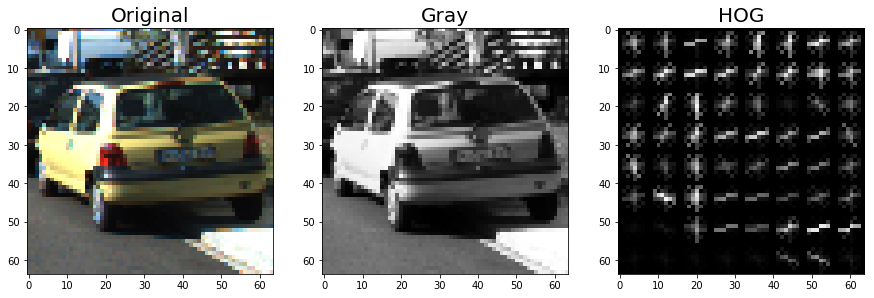

In [33]:
from lesson_functions import get_hog_features
with open('data.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 
img_path = data['vehicle']['train'][np.random.randint(0,len(data['vehicle']['train']))]
img = mpimg.imread(img_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,10))
vehicle = mpimg.imread("vehicles/GTI_Far/image0816.png")
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
non_vehicle = mpimg.imread("non-vehicles/GTI/image9.png")
ax2.imshow(gray,cmap='Greys_r')
ax2.set_title('Gray', fontsize=20)
_,hog_image = get_hog_features(gray,9,8,2,vis=True, feature_vec=True)
ax3.set_title('HOG',fontsize=20)
ax3.imshow(hog_image,cmap='Greys_r')

## HOG Features and many other features such as spatial features are very useful for training classifier as they help distinguish features between a car and a non car

In [15]:
from sklearn.svm import LinearSVC,SVC
from lesson_functions import extract_features
import time
with open('data.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 

## Local Hyper Parameters
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'



t1 = time.time()
car_train = data['car']['train']
car_train_features = extract_features(car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
non_car_train = data['non_car']['train']
non_car_train_features = extract_features(non_car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
car_test = data['car']['test']
non_car_test = data['car']['test']
car_test_features = extract_features(car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
non_car_test_features = extract_features(non_car_train,color_space=colorspace,
                                     orient=orient,pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1,2),'Seconds to extract HOG Features ..')


car_features_dict= {'train' : car_train_features, 'test' : car_test_features}
non_car_features_dict = {'train' : non_car_train_features, 'test' : non_car_test_features}
feature_dict = {'car' : car_features_dict, 'non_car' : non_car_features_dict}

print("Saving data ...")
with open('features.pickle', 'wb') as file:
    pickle.dump(feature_dict, file)
print("Saved data ...")

479.97 Seconds to extract HOG Features ..
Saving data ...
Saved data ...


In [16]:
## Local Hyper Parameters
color_space = 'YCrCb' 
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

with open('features.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 

car_train_features = data['car']['train']
non_car_train_features = data['non_car']['train']
car_test_features = data['car']['test']
non_car_test_features = data['non_car']['test']

X_train = np.vstack((car_train_features,non_car_train_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_train)

X_test = np.vstack((car_test_features,non_car_test_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler_test = StandardScaler().fit(X_test)
# Apply the scaler to X
scaled_X_test = X_scaler_test.transform(X_test)

y_train = np.hstack((np.ones(len(car_train_features)),np.zeros(len(non_car_train_features))))
y_test = np.hstack((np.ones(len(car_test_features)),np.zeros(len(non_car_test_features))))
print("Training ....")
#svc = LinearSVC()
svc = SVC()
t1 = time.time()
svc.fit(scaled_X,y_train)
t2 = time.time()
print(round(t2-t1,2),"Seconds to train SVC ...")
print("Test accuracy of SVC = ",round(svc.score(scaled_X,y_test),4))


t1 = time.time()
n_predict = 10
print("My SVC predicts: ",svc.predict(scaled_X[0:n_predict]))
print('For these',n_predict, 'labels: ',y_test[0:n_predict])
t2 = time.time()

print(round(t2-t1,5),'Seconds to predict', n_predict,'labels with SVC')

t1 = time.time()
print("Predictions for whole batch")
from sklearn.metrics import accuracy_score
y_pred = svc.predict(scaled_X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy score is ",acc)
t2 = time.time()

print(round(t2-t1,5),'Seconds to predict', n_predict,'labels with SVC')
print("Saving the classifier ...")
with open('classifier.pickle', 'wb') as file:
    pickle.dump(
     {   'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
     },file)
print("Saved ...")

Training ....
758.67 Seconds to train SVC ...
Test accuracy of SVC =  0.9997
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.89766 Seconds to predict 10 labels with SVC
Predictions for whole batch
Accuracy score is  0.999718448652
748.55244 Seconds to predict 10 labels with SVC
Saving the classifier ...
Saved ...


### Now we have the classifier. Let's talk about how to scan through a frame. For this we will use the sliding window approach similar to what we did in CNN's.

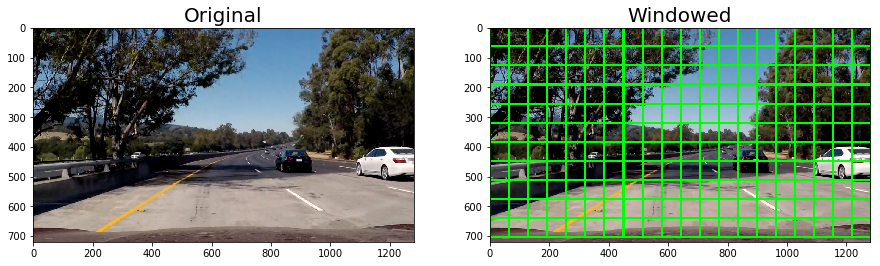

In [2]:
test_images = glob('test_images/*.jpg')
## Load the classifier
with open('classifier.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 

svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']
# Import helper functions from the class
from lesson_functions import slide_window,draw_boxes
# Read in random image
img = mpimg.imread(test_images[np.random.randint(0,len(test_images))])
windows =  slide_window(img,x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(128,128),xy_overlap=(0.5,0.5))
window_img = draw_boxes(img,windows,color=(0,255,0),thick=6)
f,(ax1,ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(window_img)
ax2.set_title('Windowed', fontsize=20)

### This approach works but there is one shortcoming. It scans the whole image, including sky where there are no cars yet! (this may change in future with flying cars :). Let's modify it a bit and restrict our scanning area

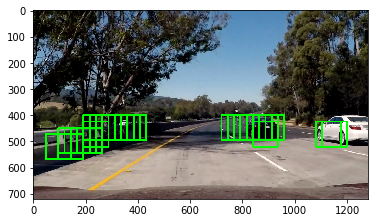

In [3]:
from lesson_functions import find_cars
ystart = 400
ystop = 656
scale = 1.5
#spatial_size = (32,32)
windows,out_img = find_cars(img,ystart,ystop,scale,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
plt.imshow(out_img)

### So, here's what we did so far

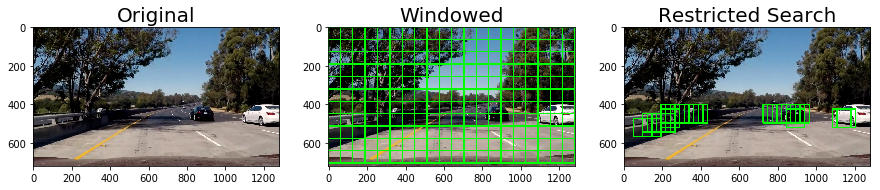

In [4]:
f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(window_img)
ax2.set_title('Windowed', fontsize=20)
ax3.imshow(out_img)
ax3.set_title('Restricted Search',fontsize=20)

### Cool, it's starting to look good, now let's remove false positives and multiple detections using heat map 

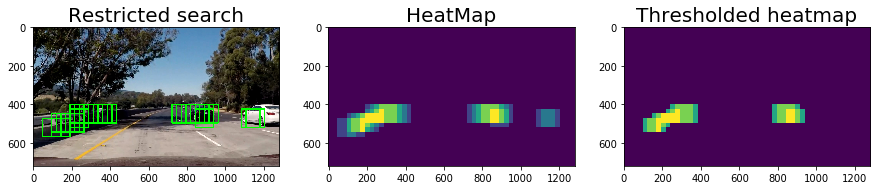

In [5]:
from lesson_functions import add_heat,apply_threshold,draw_labeled_bboxes
from scipy.ndimage.measurements import label

heat = np.zeros_like(img[:,:,0]).astype(np.float)
f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,10))
ax1.imshow(out_img)
ax1.set_title('Restricted search', fontsize=20)
heat = add_heat(heat,windows)
ax2.imshow(heat)
ax2.set_title('HeatMap', fontsize=20)
ax3.imshow(out_img)
ax3.set_title('Thresholded heatmap',fontsize=20)
heat = apply_threshold(heat,2)  
plt.imshow(heat)


## Well, that certainly looks cool. Let's visualize the outcome

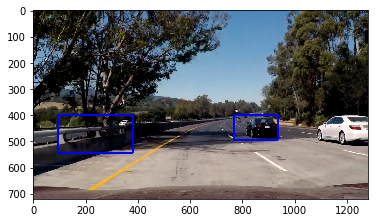

In [6]:
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap,cmap='Greys_r')
labels = label(heatmap)
# draw the bounding box on the image 
draw_image = np.copy(img)
draw_image = draw_labeled_bboxes(draw_image, labels)
plt.imshow(draw_image)

### We can remove this false detection by smoothing mutliple frames and removing something that doesn't exists in subsqeuent frames, since cars don't go *poof* in thin air, yet


In [2]:
## Let's define a pipeline 
from lesson_functions import *
from scipy.ndimage.measurements import label

with open('classifier.pickle', 'rb') as handle:                                   
    data = pickle.load(handle) 

svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

ystart = 400
ystop = 656
scale = 1.5

heatmaps = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

def pipeline(img):
    global heatmaps
    global heatmap_sum
    
    windows,out_img = find_cars(img,ystart,ystop,scale,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,windows)
    heat = apply_threshold(heat,2) 
    draw_image = np.copy(img)
    heatmap_current = np.clip(heat, 0, 255)
    
    heatmap_sum = heatmap_sum + heatmap_current
    heatmaps.append(heat)
    
    # subtract off old heat map to keep running sum of last n heatmaps
    if len(heatmaps)>12:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum,0.0,1000000.0)
    labels = label(heatmap_sum)
    draw_image = draw_labeled_bboxes(draw_image, labels)
    return draw_image




def pipeline_alt(image):
    
    scales = [1, 1.5, 2, 2.5, 4]
    y_start_stops = [[380, 460], [380, 560], [380, 620], [380, 680], [350, 700]]
    
    hot_windows = spot_cars(image, y_start_stops, scales, svc, X_scaler, 
              spatial_size, hist_bins, 
              orient, pix_per_cell, cell_per_block,
              hog_channel, spatial_feat, hist_feat, hog_feat)

    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    heat = apply_threshold(heat,3)    

    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # draw the bounding box on the image 
    draw_image = np.copy(image)
    draw_image = draw_labeled_bboxes(draw_image, labels)
    
    return draw_image
    

## Let's run it 

### First try it on test images

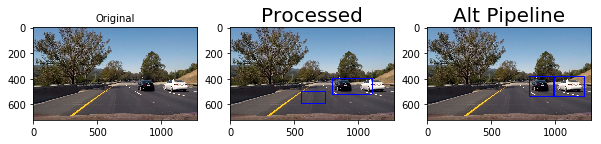

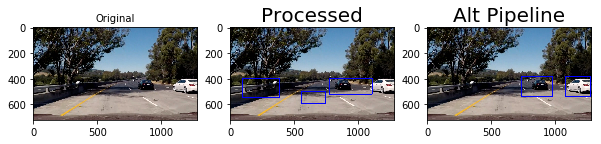

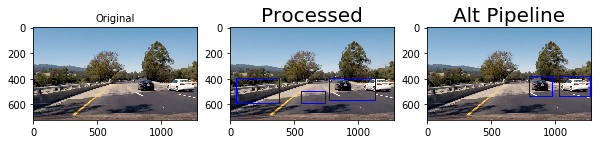

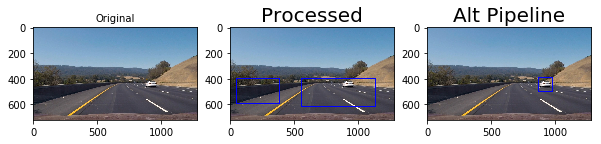

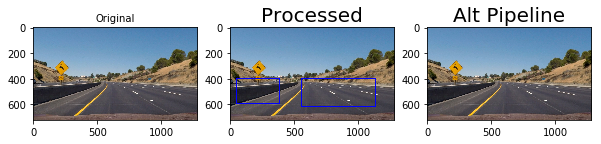

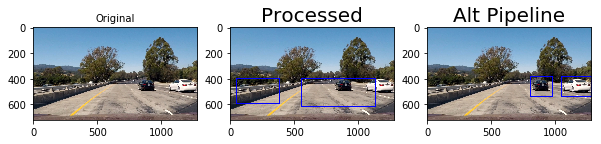

In [3]:
test_images = glob('test_images/*.jpg')

for image in test_images:
    img = mpimg.imread(image)
    plt.figure()
    f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,10))
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=10)
    ax2.imshow(pipeline(img))
    ax2.set_title('Processed', fontsize=20)
    ax3.imshow(pipeline_alt(img))
    ax3.set_title('Alt Pipeline', fontsize=20)

In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


output_file = 'project_video_processed.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(pipeline) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [5:45:28<00:23, 23.57s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 5h 31min 31s, sys: 44.5 s, total: 5h 32min 16s
Wall time: 5h 45min 34s
